Before running this file, run `kimj4_exps/param_process.py > out.csv` to get the parameter output.
Note that that file pulls data from the parameter sweep which we've uploaded to aws, so make sure to pull that. In short, the process is:
* pull aws
* run `python param_process.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [3]:
num = []
depth = []
features = []
acc = []
prec = []
recall = []
f_score = []
first = True
with open('../kimj4_exps/out.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        if not first:
            num.append(float(row[0]))
            depth.append(float(row[1]))
            features.append(float(row[2]))
            prec.append(float(row[3]))
            recall.append(float(row[4]))
            acc.append(float(row[5]))
            f_score.append(float(row[6]))
        else:
            first = False
num = np.array(num)
depth = np.array(depth)
features = np.array(features)
acc = np.array(acc)
prec = np.array(prec)
recall = np.array(recall)
f_score = np.array(f_score)

As long as we have more features than depth, we should get decent results:

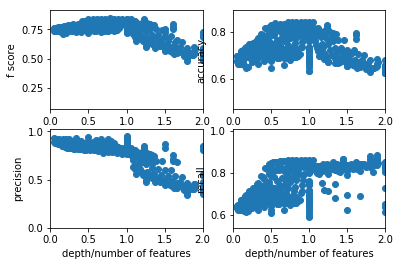

In [15]:
df_ratio = depth/features
plt.subplot(2,2,1)
plt.scatter(df_ratio, f_score)
plt.xlabel('depth/number of features')
plt.ylabel('f score')
plt.gca().set_xlim([0,2])

plt.subplot(2,2,2)
plt.scatter(df_ratio, acc)
plt.xlabel('depth/number of features')
plt.ylabel('accuracy')
plt.gca().set_xlim([0,2])

plt.subplot(2,2,3)
plt.scatter(df_ratio, prec)
plt.xlabel('depth/number of features')
plt.ylabel('precision')
plt.gca().set_xlim([0,2])

plt.subplot(2,2,4)
plt.scatter(df_ratio, recall)
plt.xlabel('depth/number of features')
plt.ylabel('recall')
plt.gca().set_xlim([0,2])

plt.show()

It seems that a high number of features/depth gives good results. As a sanity check, increasing the depth or number of features, while holding the number of trees constant, gives better results as well (more information -> better-informed decisions -> more accurate forest). Finally, it seems that keeping a depth/features ratio of around/slightly under 1 is best for high-accuracy results

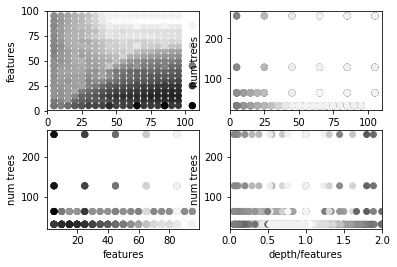

In [23]:
plt.subplot(2,2,1)
plt.scatter(depth, features, c=acc)
plt.xlabel('depth')
plt.ylabel('features')
plt.gray()

plt.subplot(2,2,2)
plt.scatter(depth, num, c=acc)
plt.xlabel('depth')
plt.ylabel('num trees')
plt.gray()

plt.subplot(2,2,3)
plt.scatter(features, num, c=acc)
plt.xlabel('features')
plt.ylabel('num trees')
plt.gray()


plt.subplot(2,2,4)
plt.scatter(df_ratio, num, c=acc)
plt.xlabel('depth/features')
plt.ylabel('num trees')
plt.gray()
plt.gca().set_xlim([0,2])

plt.show()

Here's the same graph, but with f1 instead of accuracy as the color.

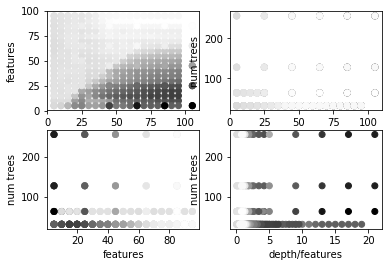

In [25]:
plt.subplot(2,2,1)
plt.scatter(depth, features, c=f_score)
plt.xlabel('depth')
plt.ylabel('features')
plt.gray()

plt.subplot(2,2,2)
plt.scatter(depth, num, c=f_score)
plt.xlabel('depth')
plt.ylabel('num trees')
plt.gray()

plt.subplot(2,2,3)
plt.scatter(features, num, c=f_score)
plt.xlabel('features')
plt.ylabel('num trees')
plt.gray()


plt.subplot(2,2,4)
plt.scatter(df_ratio, num, c=f_score)
plt.xlabel('depth/features')
plt.ylabel('num trees')
plt.gray()
# plt.gca().set_xlim([0,2])

plt.show()

There seems to be a local maximum around the mid .8's. Will increasing the # of trees on those points help?

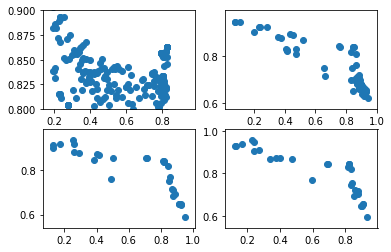

In [78]:
def filter_func():
    return num==tree_filter

plt.subplot(2,2,1)
tree_filter = 32
plt.scatter(prec[filter_func()], recall[filter_func()])
plt.gca().set_ylim([.8,.9])
plt.subplot(2,2,2)
tree_filter = 64
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,3)
tree_filter = 128
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,4)
tree_filter = 256
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.show()

Doing some narrowing down. We're looking for that point slightly above .8 and .85 in the 32-tree example. 

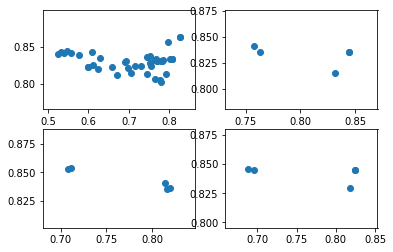

In [79]:
def filter_func():
    right_tree = num==tree_filter
    right_params = np.logical_and(np.logical_and(np.greater_equal(df_ratio, np.ones(df_ratio.shape)),
                                  np.greater(features, 50*np.ones(features.shape))),
                                  np.greater(depth, 50*np.ones(features.shape)))
    return np.logical_and(right_tree, right_params)

plt.subplot(2,2,1)
tree_filter = 32
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,2)
tree_filter = 64
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,3)
tree_filter = 128
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,4)
tree_filter = 256
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.show()

And finally, finding the exact point

[ 32.  32.]
[ 95.  95.]
[ 90.  95.]
[ 0.82617882  0.79621241]
[ 0.8626045   0.85691365]


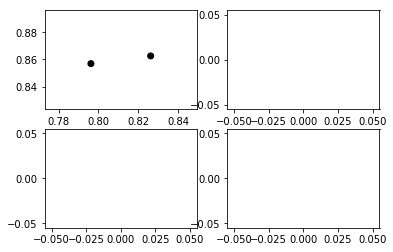

In [82]:
def filter_func():
    right_tree = num==tree_filter
    right_params = np.logical_and(features > 85, depth > 90)
    return np.logical_and(right_tree, right_params)

plt.subplot(2,2,1)
tree_filter = 32
plt.scatter(prec[filter_func()], recall[filter_func()], c=depth[filter_func()])
print(num[filter_func()])
print(depth[filter_func()])
print(features[filter_func()])
print(prec[filter_func()])
print(recall[filter_func()])

plt.subplot(2,2,2)
tree_filter = 64
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,3)
tree_filter = 128
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.subplot(2,2,4)
tree_filter = 256
plt.scatter(prec[filter_func()], recall[filter_func()])

plt.show()

Looks like our max is at `(32,95,90)` for `(n_trees, depth, features)`.